# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **FPL player score** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, combine predictions with static data
3. Store predictions in a monitoring feature group

## <span style='color:#ff5f27'> 📝 Imports

In [177]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
from importlib import reload
import requests

In [178]:
reload(util)

print(util.get_gameweek_from_date("2025-1-4"))

20


In [179]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)

# Get the gameweek from the date
gameweek = util.get_gameweek_from_date(str(today.date()))
last_gameweek = gameweek - 1

gameweek
last_gameweek

19

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [180]:
try:
    with open('./hopsworks/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
except:
    print("In production mode")

project = hopsworks.login()
fs = project.get_feature_store()

2025-01-06 15:25:15,753 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-06 15:25:15,762 INFO: Initializing external client
2025-01-06 15:25:15,763 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 15:25:17,026 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159321


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [181]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="player_score_xgboost_model",
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-01-06 15:25:18,646 WARNING: VersionWarning: No version provided for getting model `player_score_xgboost_model`, defaulting to `1`.



In [182]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.5633903E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'floa...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
bootstrap_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
general_info = requests.get(bootstrap_url).json()

with open ('./state/prev_gameweek.txt', 'r') as file:
    prev_gameweek = file.readline()

prev_gameweek = next(
    (gw for gw in general_info['events'] if gw['id'] == int(prev_gameweek)), None
)
prev_finished = prev_gameweek['finished']

current_gameweek = next(
    (gw for gw in general_info['events'] if gw['is_current']), None
)

## <span style="color:#ff5f27;">✨ Get Player Score Features From Previous Gameweek </span>



In [ ]:
if prev_gameweek["id"] != current_gameweek["id"] and prev_finished:
    players_fg = fs.get_feature_group(
        name='player_features',
        version=1,
    )
    players = players_fg.filter(players_fg.gameweek == gameweek-1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
players.head()

,id,points,gameweek,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,...,prev_expected_goals,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam,prev_total_points,prev_selected,prev_transfers_balance,prev_value,prev_was_home
0,88,1,19,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.12,0.00,0.12,1.29,0.0,55.0,266161.0,-18145.0,46.0,0.0
1,489,2,19,90.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.01,0.01,1.12,0.0,16.0,18410.0,2277.0,46.0,0.0
2,275,1,19,79.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.00,0.00,1.94,0.0,12.0,251828.0,7338.0,39.0,0.0
3,486,1,19,86.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.02,0.02,1.09,0.0,21.0,42344.0,-1195.0,43.0,0.0
4,144,1,19,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.00,0.05,0.05,0.93,1.0,40.0,107453.0,-10799.0,45.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,508,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,37.0,211771.0,-11467.0,48.0,0.0
486,365,1,19,27.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.03,0.05,0.08,0.55,0.0,5.0,22511.0,-217.0,57.0,0.0
487,201,2,19,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.00,0.00,0.00,1.47,0.0,62.0,1159490.0,-7314.0,44.0,0.0
488,193,1,19,37.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.04,0.04,0.28,0.0,13.0,5694.0,-45.0,49.0,0.0


In [185]:
inputs = ['prev_minutes', 'prev_goals_scored', 'prev_assists',
         'prev_clean_sheets', 'prev_goals_conceded', 'prev_own_goals',
         'prev_penalties_saved', 'prev_penalties_missed', 'prev_yellow_cards',
         'prev_red_cards', 'prev_saves', 'prev_bonus',
         'prev_bps', 'prev_influence', 'prev_creativity',
         'prev_threat', 'prev_ict_index', 'prev_starts',
         'prev_expected_goals', 'prev_expected_assists', 'prev_expected_goal_involvements',
         'prev_expected_goals_conceded', 'prev_in_dreamteam', 'prev_total_points', 
         'prev_selected', 'prev_transfers_balance', 'prev_value', 'prev_was_home']

#for i in range(0, len(input_data)):
#    output_data.at[i, 'predicted_score'] = retrieved_xgboost_model.predict(input_data.loc[i, inputs].values.reshape(1, -1))[0]

if prev_gameweek["id"] != current_gameweek["id"] and prev_finished:
    players['predicted_score'] = retrieved_xgboost_model.predict(players[inputs]).astype("float64")


players.head()

,id,points,gameweek,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,...,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam,prev_total_points,prev_selected,prev_transfers_balance,prev_value,prev_was_home,predicted_score
0,88,1,19,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.00,0.12,1.29,0.0,55.0,266161.0,-18145.0,46.0,0.0,1.404104
1,489,2,19,90.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.01,0.01,1.12,0.0,16.0,18410.0,2277.0,46.0,0.0,1.574734
2,275,1,19,79.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.00,1.94,0.0,12.0,251828.0,7338.0,39.0,0.0,0.941604
3,486,1,19,86.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.02,0.02,1.09,0.0,21.0,42344.0,-1195.0,43.0,0.0,2.760482
4,144,1,19,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.05,0.05,0.93,1.0,40.0,107453.0,-10799.0,45.0,1.0,1.031906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,508,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,37.0,211771.0,-11467.0,48.0,0.0,0.603922
486,365,1,19,27.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.05,0.08,0.55,0.0,5.0,22511.0,-217.0,57.0,0.0,1.420221
487,201,2,19,90.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.00,0.00,1.47,0.0,62.0,1159490.0,-7314.0,44.0,0.0,1.587603
488,193,1,19,37.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04,0.04,0.28,0.0,13.0,5694.0,-45.0,49.0,0.0,1.264141


In [186]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               490 non-null    int64  
 1   points                           490 non-null    int64  
 2   gameweek                         490 non-null    int64  
 3   prev_minutes                     490 non-null    float64
 4   prev_goals_scored                490 non-null    float64
 5   prev_assists                     490 non-null    float64
 6   prev_clean_sheets                490 non-null    float64
 7   prev_goals_conceded              490 non-null    float64
 8   prev_own_goals                   490 non-null    float64
 9   prev_penalties_saved             490 non-null    float64
 10  prev_penalties_missed            490 non-null    float64
 11  prev_yellow_cards                490 non-null    float64
 12  prev_red_cards        

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

### Create Score Graph
Draw a graph of the predictions with all the players as a PNG and save it to the github

2025-01-06 15:25:23,744 WARNING: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.



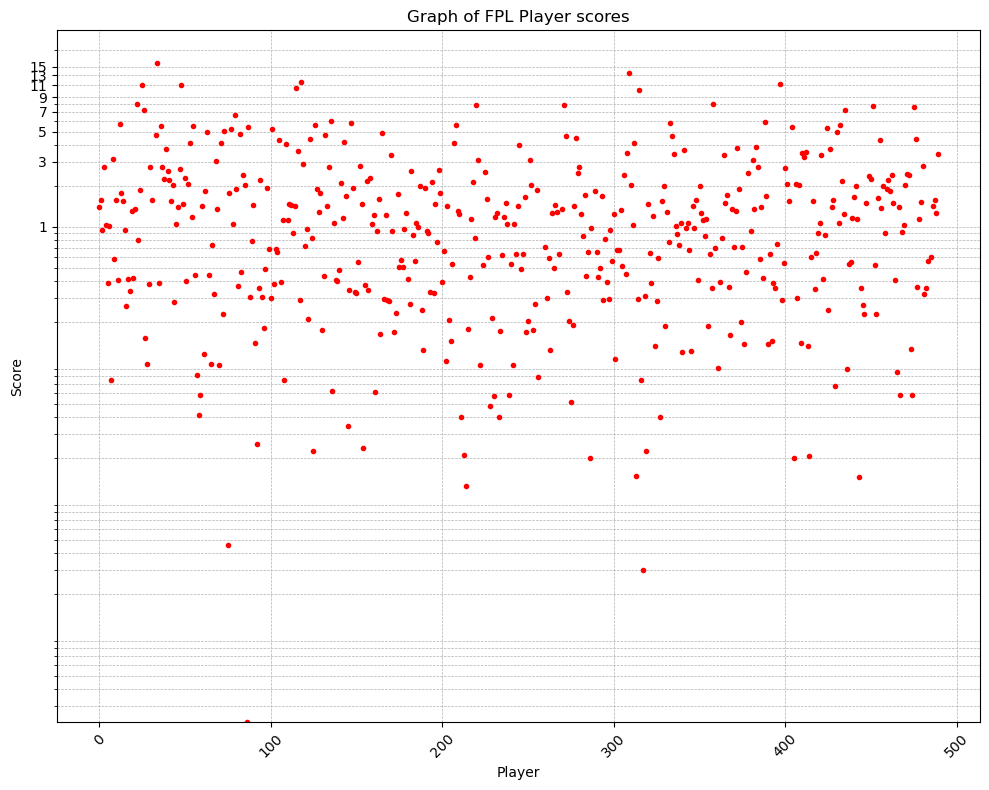

In [187]:
if prev_gameweek["id"] != current_gameweek["id"] and prev_finished:
    file_path = "./player_score_model/images/predicted_scores.png"
    plt = util.plot_player_score_forecast("FPL Player scores", players, file_path)
    plt.show()

In [188]:
if prev_gameweek["id"] != current_gameweek["id"] and prev_finished:
    # Get or create feature group
    monitor_fg = fs.get_or_create_feature_group(
        name='fpl_predictions',
        description='FPL player score prediction monitoring',
        version=1,
        primary_key=['id', 'gameweek']
    )

In [189]:
if prev_gameweek["id"] != current_gameweek["id"] and prev_finished:
    # Only keep the relevant columns
    output_data = players[['id', 'points', 'gameweek', 'predicted_score']]

    output_data

,id,points,gameweek,predicted_score
0,88,1,19,1.404104
1,489,2,19,1.574734
2,275,1,19,0.941604
3,486,1,19,2.760482
4,144,1,19,1.031906
...,...,...,...,...
485,508,0,19,0.603922
486,365,1,19,1.420221
487,201,2,19,1.587603
488,193,1,19,1.264141


In [190]:
if prev_gameweek["id"] != current_gameweek["id"] and prev_finished:
    # Add static data
    for i in range(0, len(output_data)):
        player_id = output_data.loc[i, 'id']

        player_data = util.get_player_info(player_id,general_info)
        for key in player_data:
            output_data.at[i, key] = player_data[key]

2025-01-06 15:25:24,498 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-01-06 15:25:24,498 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-01-06 15:25:24,499 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-01-06 15:25:24,499 WARNING: S

In [193]:
output_data.dtypes

id                            int64
points                        int64
gameweek                      int64
predicted_score             float64
first_name                   object
second_name                  object
team                         object
position                     object
previous_predicted_score      int64
dtype: object

In [ ]:
if prev_gameweek["id"] != current_gameweek["id"] and prev_finished:
    monitor_fg.insert(output_data)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1159321/fs/1150024/fg/1394654


Uploading Dataframe: 100.00% |██████████| Rows 490/490 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: fpl_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1159321/jobs/named/fpl_predictions_1_offline_fg_materialization/executions


(Job('fpl_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [195]:
if prev_gameweek["id"] != current_gameweek["id"] and prev_finished:
    monitor_fg.update_feature_description("id", "Player ID")
    monitor_fg.update_feature_description("points", "Total points of the player in the gameweek (label)")
    monitor_fg.update_feature_description("gameweek", "Gameweek")
    monitor_fg.update_feature_description("predicted_score", "Predicted score of the player in the gameweek")
    monitor_fg.update_feature_description("first_name", "Player first name")
    monitor_fg.update_feature_description("second_name", "Player surname")
    monitor_fg.update_feature_description("team", "Player team")
    monitor_fg.update_feature_description("position", "Player position")
    monitor_fg.update_feature_description("previous_predicted_score", "Previous (max 5) predicted scores of the player")


---